# **Group 5 ED(C) Deep Learning Approach with the use of Transformers - Training**

In [1]:
# Code for cloning the git repository

# !git clone https://github.com/ymahajan1612/NLU-Evidence-Detection
# %cd NLU-Evidence-Detection/
# !git checkout bert_standard


Cloning into 'NLU-Evidence-Detection'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 89 (delta 38), reused 65 (delta 17), pack-reused 0 (from 0)
Receiving objects: 100% (89/89), 2.39 MiB | 12.68 MiB/s, done.
Resolving deltas: 100% (38/38), done.
/content/NLU-Evidence-Detection
Branch 'bert_standard' set up to track remote branch 'bert_standard' from 'origin'.
Switched to a new branch 'bert_standard'


Import necessary libraries

In [ ]:
from claims_dataset import ClaimEvidenceDataset
from evidence_classifier import EvidenceClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

Split the data for training and validation

In [3]:
train_df = pd.read_csv('data/train.csv')
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state= 42)

train_df.to_csv('train_split.csv', index=False)
val_df.to_csv('val_split.csv', index=False)

Define the Trainer class

In [ ]:
class Trainer:
    def __init__(self, train_csv, validation_csv, epochs=5):
        self.epochs = epochs
        # Define the dataset class
        self.train_dataset = ClaimEvidenceDataset(train_csv)
        self.val_dataset = ClaimEvidenceDataset(validation_csv)

        self.train_loader = DataLoader(self.train_dataset, batch_size=8, shuffle=True)
        self.val_loader = DataLoader(self.val_dataset, batch_size=8, shuffle=False)

        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.model = EvidenceClassifier().to(self.device)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=2e-5)

        self.best_accuracy = float('-inf')

        self.train_loss = []
        self.val_loss = []

    def plot_loss(self):
        plt.plot(self.train_loss, label='Train Loss')
        plt.plot(self.val_loss, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()


    def trainModel(self):
        for epoch in range(self.epochs):
            # Training Phase
            self.model.train()
            train_loss = 0
            for batch in self.train_loader:
                self.optimizer.zero_grad()

                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                token_type_ids = batch['token_type_ids'].to(self.device)
                labels = batch['labels'].to(self.device)

                logits = self.model(input_ids, attention_mask, token_type_ids)
                loss = self.criterion(logits, labels)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()

            train_loss /= len(self.train_loader)

            # Validation Phase
            self.model.eval()
            val_loss = 0
            correct = 0
            total = 0

            with torch.no_grad():
                for batch in self.val_loader:
                    input_ids = batch['input_ids'].to(self.device)
                    attention_mask = batch['attention_mask'].to(self.device)
                    token_type_ids = batch['token_type_ids'].to(self.device)
                    labels = batch['labels'].to(self.device)

                    logits = self.model(input_ids, attention_mask, token_type_ids)
                    loss = self.criterion(logits, labels)
                    val_loss += loss.item()

                    predictions = torch.argmax(logits, dim=1)
                    correct += (predictions == labels).sum().item()
                    total += labels.size(0)

            val_loss /= len(self.val_loader)
            val_accuracy = correct / total

            self.train_loss.append(train_loss)
            self.val_loss.append(val_loss)

            print(f'Epoch {epoch+1}/{self.epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

            if val_accuracy > self.best_accuracy:
                self.best_accuracy = val_accuracy
                torch.save(self.model.state_dict(), 'ED_model_C.pth')
                print('Saved best model')


Train the model

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1/5, Train Loss: 0.3573, Val Loss: 0.2818, Val Accuracy: 0.8712
Saved best model
Epoch 2/5, Train Loss: 0.2126, Val Loss: 0.2792, Val Accuracy: 0.8770
Saved best model
Epoch 3/5, Train Loss: 0.1014, Val Loss: 0.3738, Val Accuracy: 0.8645
Epoch 4/5, Train Loss: 0.0545, Val Loss: 0.5022, Val Accuracy: 0.8740
Epoch 5/5, Train Loss: 0.0336, Val Loss: 0.5475, Val Accuracy: 0.8696


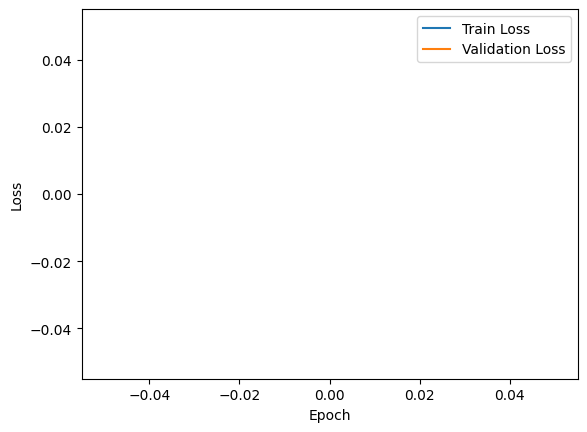

In [5]:
model_trainer = Trainer('train_split.csv', 'val_split.csv')
model_trainer.trainModel()

Plot validation and training losses

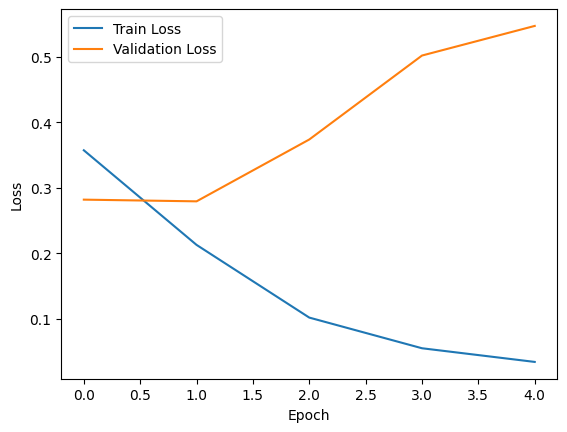

In [7]:
model_trainer.plot_loss()
